# HAM10000 with augmented dataset
All preprocessing are done in "preprocessing.ipynb"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
import seaborn as sb
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from tqdm import tqdm
import cv2
import random
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools

In [2]:
base_skin_dir = os.path.join('..', 'input')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

# all_image_path = glob(os.path.join(base_skin_dir, '*', '*.jpg'))
# imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
#                      for x in all_image_path}

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

### Plot model validation loss and acc.

In [3]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [4]:
# def compute_img_mean_std(image_paths):
#     """
#         computing the mean and std of three channel on the whole dataset,
#         first we should normalize the image from 0-255 to 0-1
#     """

#     img_h, img_w = 224, 224
#     imgs = []
#     means, stdevs = [], []

#     for i in tqdm(range(len(image_paths))):
#         img = cv2.imread(image_paths[i])
#         img = cv2.resize(img, (img_h, img_w))
#         imgs.append(img)

#     imgs = np.stack(imgs, axis=3)
#     print(imgs.shape)

#     imgs = imgs.astype(np.float32) / 255.

#     for i in range(3):
#         pixels = imgs[:, :, i, :].ravel()  # resize to one row
#         means.append(np.mean(pixels))
#         stdevs.append(np.std(pixels))

#     means.reverse()  # BGR --> RGB
#     stdevs.reverse()

#     print("normMean = {}".format(means))
#     print("normStd = {}".format(stdevs))
#     return means,stdevs


In [5]:
# df = pd.read_csv(os.path.join(base_skin_dir, 'aug_HAM10000_metadata.csv'))
df = pd.read_csv('aug_HAM10000_metadata.csv')
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicated?,train_value
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,dup,train
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,dup,train
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,dup,train
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,dup,train
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,dup,train


In [6]:
# norm_mean,norm_std = compute_img_mean_std(df['path'])

### Check
Just to double check

In [7]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
dataset          0
path             0
cell_type        0
cell_type_idx    0
duplicated?      0
train_value      0
dtype: int64

<AxesSubplot: >

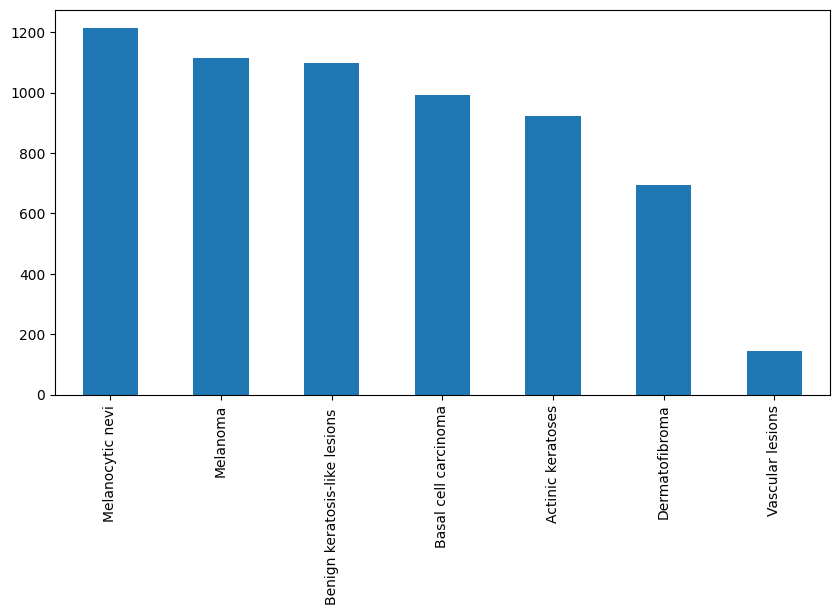

In [8]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<AxesSubplot: >

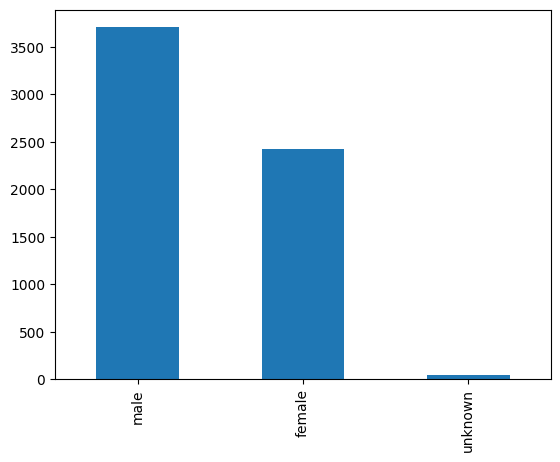

In [9]:
df['sex'].value_counts().plot(kind='bar')

<AxesSubplot: >

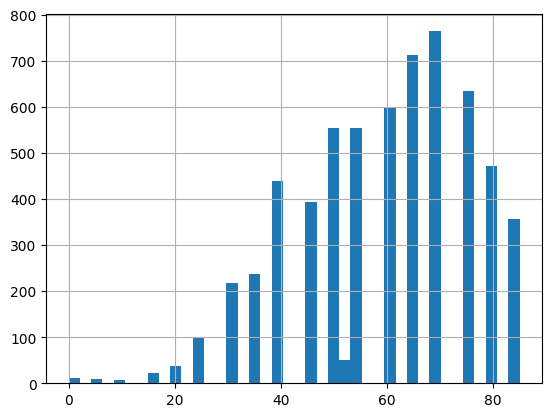

In [10]:
df['age'].hist(bins=40)

<AxesSubplot: >

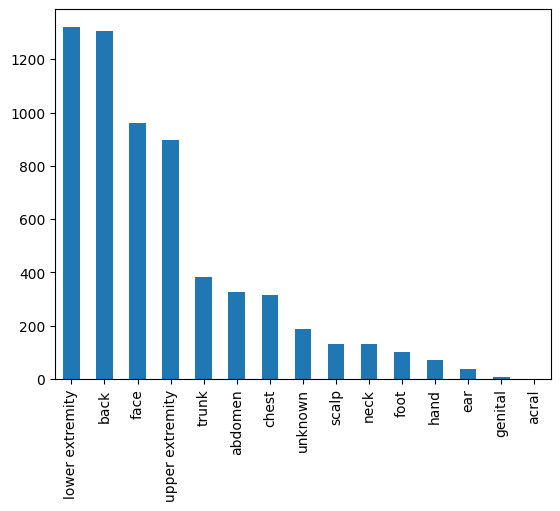

In [11]:
df['localization'].value_counts().plot(kind='bar')

### Resize Image
It's gonna take some time

In [12]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,path,cell_type,cell_type_idx,duplicated?,train_value,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0027419.jpg,Benign keratosis-like lesions,2,dup,train,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025030.jpg,Benign keratosis-like lesions,2,dup,train,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0026769.jpg,Benign keratosis-like lesions,2,dup,train,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,..\input\HAM10000_images_part_1\ISIC_0025661.jpg,Benign keratosis-like lesions,2,dup,train,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,..\input\HAM10000_images_part_2\ISIC_0031633.jpg,Benign keratosis-like lesions,2,dup,train,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


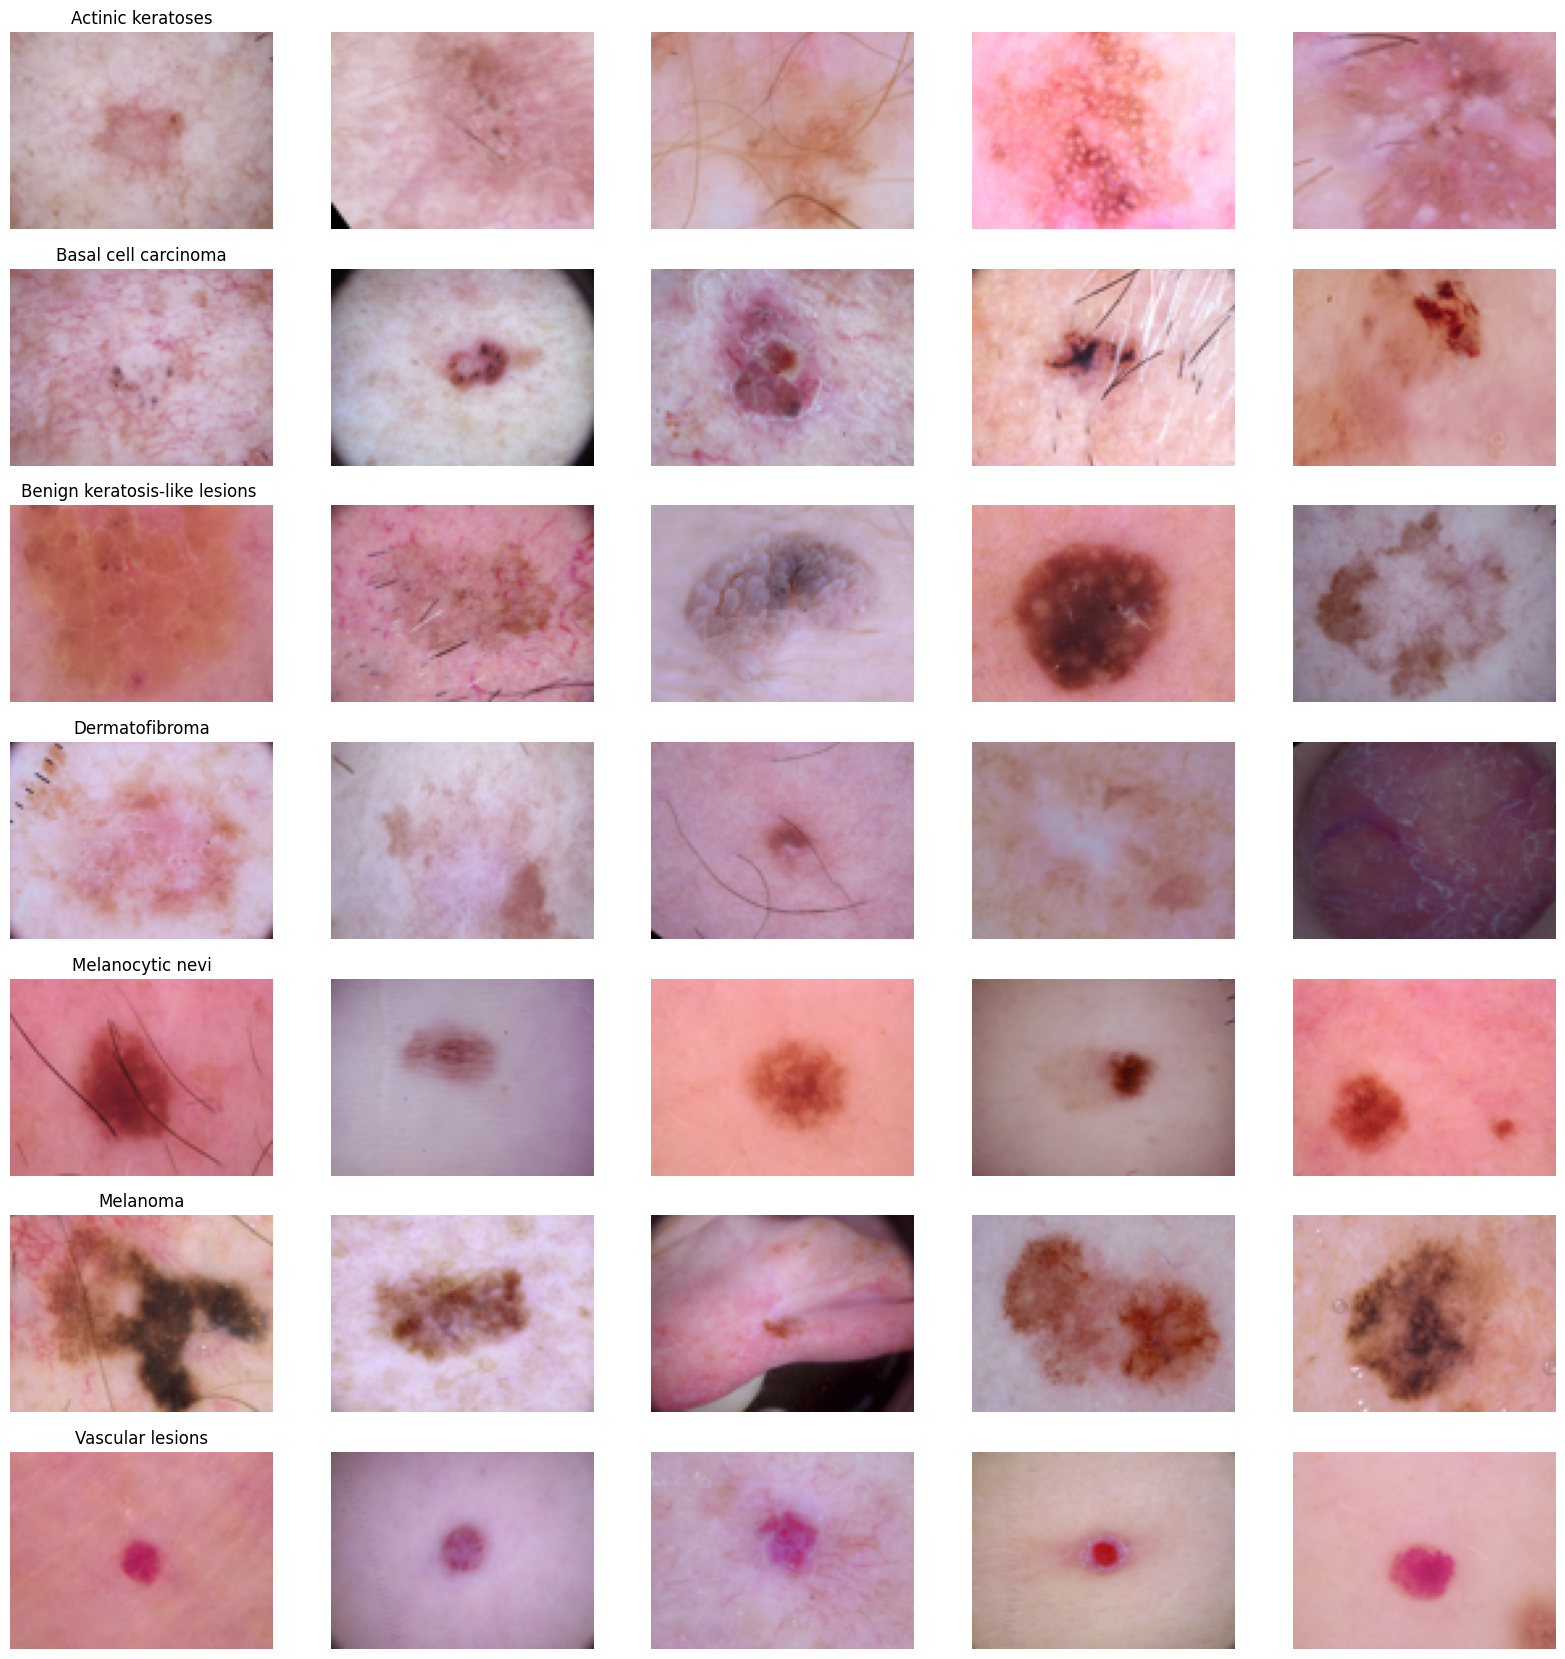

In [13]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
# fig.savefig('category_samples.png', dpi=300)

In [14]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    6176
Name: image, dtype: int64

In [15]:
df['image'][0][0][0]

array([190, 153, 194], dtype=uint8)

### Split data set
It's already done in 'preprocessing.ipynb'

In [16]:
features=df.drop(columns=['cell_type_idx'],axis=1)
target=df['cell_type_idx']
x_train = df[df['train_value']=='train'].drop(columns=['cell_type_idx', 'path', 'cell_type', 'duplicated?', 'train_value'], axis=1)
x_test = df[df['train_value']=='value'].drop(columns=['cell_type_idx', 'path', 'cell_type', 'duplicated?', 'train_value'], axis=1)
y_train = df[df['train_value']=='train']['cell_type_idx']
y_test = df[df['train_value']=='value']['cell_type_idx']

In [17]:
x_train.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,"[[[190, 153, 194], [192, 154, 196], [191, 153,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,"[[[23, 13, 22], [24, 14, 24], [25, 14, 28], [3..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,"[[[185, 127, 137], [189, 133, 147], [194, 136,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,"[[[24, 11, 17], [26, 13, 22], [38, 21, 32], [5..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,"[[[134, 90, 113], [147, 102, 125], [159, 115, ..."


In [18]:
y_train.value_counts()

5    1067
2    1011
4     971
1     958
0     891
3     685
6     130
Name: cell_type_idx, dtype: int64

### Normalization

In [19]:
# np.mean(np.asarray(x_train['image'].tolist()))

In [20]:
x_train = np.asarray(x_train['image'].tolist(), dtype=np.float32)/255
x_test = np.asarray(x_test['image'].tolist(), dtype=np.float32)/255

# x_train_mean = np.mean(x_train)
# x_train_std = np.std(x_train)

# x_test_mean = np.mean(x_test)
# x_test_std = np.std(x_test)

# x_train = (x_train - x_train_mean)/x_train_std
# x_test = (x_test - x_test_mean)/x_test_std

In [21]:
# print(x_train_mean, x_train_std, x_test_mean, x_test_std)

In [22]:
type(x_train[0][0][0][0])

numpy.float32

In [23]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

### Split into train and validation

In [24]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [25]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

### Build Model

In [26]:
# Set the CNN model 
# my CNN architechture is In -> [[Conv2D->relu]*2 -> MaxPool2D -> Dropout]*2 -> Flatten -> Dense -> Dropout -> Out
input_shape = (75, 100, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.30))# 0.2

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.30))# 0.3 0.2

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))# 0.3 0.2
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 37, 50, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 25, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 18, 25, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 25, 64)        1

In [27]:
# Define the optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

c:\Users\Jeff\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [28]:
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [29]:
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [30]:
# With data augmentation to prevent overfitting 

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images

# datagen.fit(x_train)

In [31]:
# Fit the model
epochs = 100 # best 20
batch_size = 5
batch = 5
history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch
                              , callbacks=[learning_rate_reduction])
# history = model.fit(x=x_train, y=y_train, batch_size=batch, epochs=epochs, verbose='auto', callbacks=[learning_rate_reduction], validation_data=(x_validate, y_validate))#, steps_per_epoch=x_train.shape[0])

C:\Users\Jeff\AppData\Local\Temp\ipykernel_16228\3653893958.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch),


Epoch 1/100
1028/1028 [==============================] - 10s 8ms/step - loss: 1.8084 - accuracy: 0.2227 - val_loss: 1.7173 - val_accuracy: 0.2832 - lr: 0.0010
Epoch 2/100
1028/1028 [==============================] - 7s 7ms/step - loss: 1.6395 - accuracy: 0.3127 - val_loss: 1.5855 - val_accuracy: 0.3042 - lr: 0.0010
Epoch 3/100
1028/1028 [==============================] - 8s 7ms/step - loss: 1.5913 - accuracy: 0.3359 - val_loss: 1.5082 - val_accuracy: 0.3951 - lr: 0.0010
Epoch 4/100
1028/1028 [==============================] - 8s 7ms/step - loss: 1.5436 - accuracy: 0.3697 - val_loss: 1.4505 - val_accuracy: 0.4248 - lr: 0.0010
Epoch 5/100
1028/1028 [==============================] - 7s 7ms/step - loss: 1.5000 - accuracy: 0.3904 - val_loss: 1.4101 - val_accuracy: 0.4493 - lr: 0.0010
Epoch 6/100
1028/1028 [==============================] - 8s 7ms/step - loss: 1.4678 - accuracy: 0.3941 - val_loss: 1.4241 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 7/100
1028/1028 [============================

In [32]:
# model = load_model('./past_models/model_813.h5')
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
# loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
# print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
#model.save("model.h5")

15/15 [==============================] - 0s 14ms/step - loss: 0.9343 - accuracy: 0.6393
Test: accuracy = 0.639309  ;  loss = 0.934285


In [33]:
model.save('model_4.h5')

TypeError: 7.0 must be a sequence

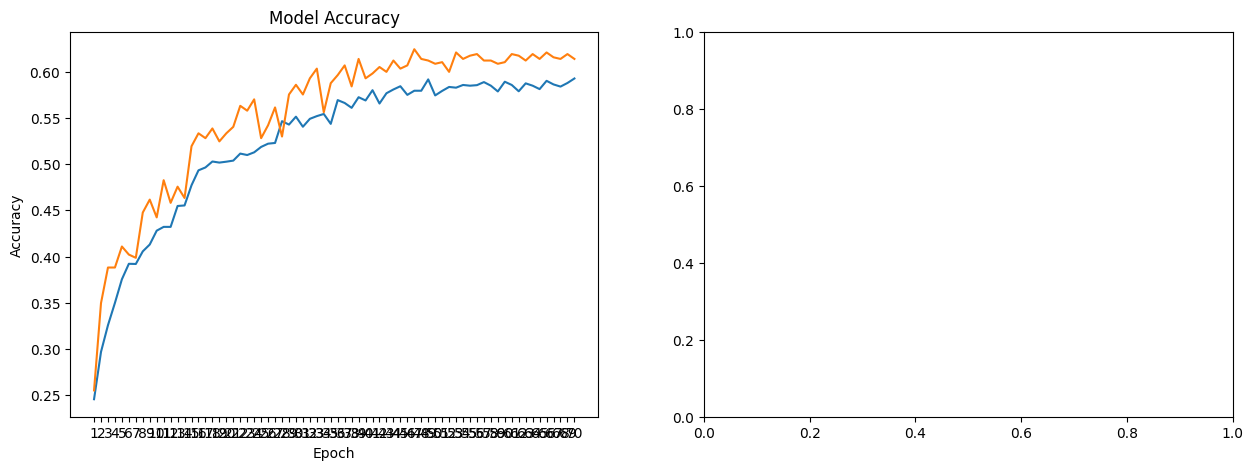

In [34]:
plot_model_history(history)

18/18 [==============================] - 0s 4ms/step


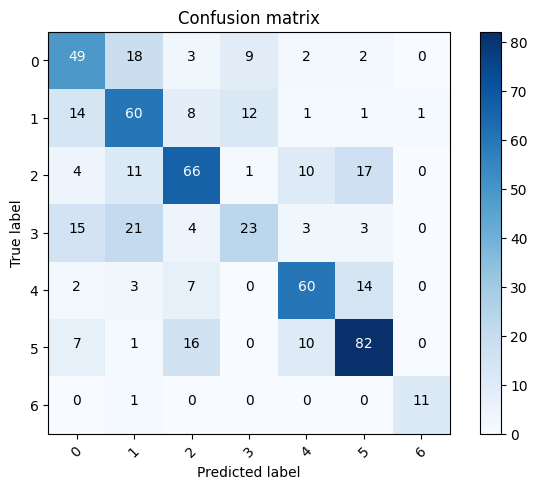

In [35]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

 

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

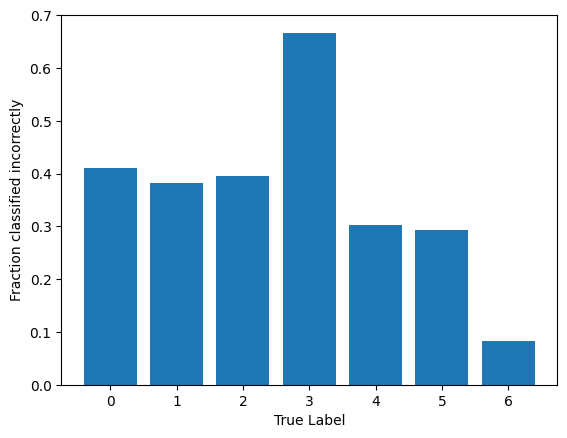

In [36]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

### Testing

In [23]:
model = load_model('./past_models/model_813.h5')
test_img = (np.asarray(Image.open('..\input\HAM10000_images_part_1\ISIC_0026769.jpg').resize((100,75)))-157)/157
print(test_img.shape)
test_img = test_img.reshape(1, 75, 100, 3)
print(model.predict(test_img))


(75, 100, 3)
1/1 [==============================] - 0s 267ms/step
[[2.4027993e-04 2.4652830e-01 6.8543911e-01 1.0205451e-05 5.5588830e-02
  1.2193273e-02 3.7383563e-09]]
